### Idées pour pipline nlp dans l'application streamlit + idée d'exploitations des codes APE

In [16]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 85.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.9/835.9 kB 77.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 83.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 58.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 68.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16/16 [spacy]m15/16 [spacy]d]sh]


In [19]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 45.6 MB/s  0:00:00 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


In [34]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 28.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19/19 [langchain_community]ngchain_community]ters]


In [1]:
from data.load_idf_10_24 import load_base

In [68]:
data = load_base()

Data Frame idf_10_24 récupéré depuis S3


In [14]:
for i in range(100,105):
    print(data.loc[data["objet"]!="non-disp"]["objet"].iloc[i])

Bar - café - débit de boissons - restauration rapide
RESTAURATION RAPIDE
Négoce de produits et matériels de laboratoires.
FABRICATION VENTE A EMPORTER PIZZA
PREPARATION PLAT CUISINIER A EMPORTER


In [69]:
data = data.loc[data["objet"]!="non-disp"]

In [ ]:
from typing import List
import spacy

def clean_docs(
    texts: List[str],
    remove_stopwords: bool = False,
    n_process: int = 4,
    remove_punctuation: bool = True
) -> List[str]:
    """
    Cleans a list of text documents by tokenizing, optionally removing stopwords, and optionally removing punctuation.

    Parameters:
        texts (List[str]): List of text documents to clean.
        remove_stopwords (bool): Whether to remove stopwords. Default is False.
        n_process (int): Number of processes to use for processing. Default is 4.
        remove_punctuation (bool): Whether to remove punctuation. Default is True.

    Returns:
        List[str]: List of cleaned text documents.
    """
    # Load spacy's nlp model
    docs = nlp.pipe(
        texts,
        n_process=n_process,
        disable=['parser', 'ner', 'lemmatizer', 'textcat']
    )

    # Pre-load stopwords for faster checking
    stopwords = set(nlp.Defaults.stop_words)

    # Process documents
    docs_cleaned = (
        ' '.join(
            tok.text.lower().strip()
            for tok in doc
            if (not remove_punctuation or not tok.is_punct) and
               (not remove_stopwords or tok.text.lower() not in stopwords)
        )
        for doc in docs
    )

    return list(docs_cleaned)

In [4]:
nlp = spacy.load('fr_core_news_sm')

In [70]:
data["text_clean"] = clean_docs(data["objet"],remove_stopwords=True,remove_punctuation=True)

In [7]:
from langchain_community.retrievers import TFIDFRetriever
from langchain_community.document_loaders import DataFrameLoader

In [139]:
data_t = data[["text_clean","ape_min"]]

In [140]:
loader = DataFrameLoader(data_t, page_content_column="text_clean")

retriever = TFIDFRetriever.from_documents(
    loader.load()
)

In [14]:
import pandas as pd

In [143]:
exemple = "chicha"

documents = []
for best_echoes in retriever.invoke(exemple):
    documents += [{**best_echoes.metadata, **{"text_clean": best_echoes.page_content}}]

documents = pd.DataFrame(documents)

documents

,ape_min,text_clean
0,5610A,restaurant chicha
1,5610A,restaurant bar chicha
2,5610C,restauration rapide bar chicha
3,563,bar brasserie chicha


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

activites_annotees = [
    ("4511Z", "Commerce de voitures et véhicules légers"),
    ("4519Z", "Commerce d'autres véhicules automobiles"),
    ("45",    "Entretien et réparation véhicules automobiles"),
    ("454",   "Commerce et réparation de motocyclettes"),
    ("461",   "Intermédiaires du commerce de gros"),
    ("462",   "Commerce de gros produits agricoles et animaux vivants"),
    ("463",   "Commerce de gros aliments, boissons et tabac"),
    ("466",   "Commerce de gros autres équipements industriels"),
    ("467",   "Autres commerces de gros spécialisés"),
    ("471",   "Commerce de détail en magasin non spécialisé"),
    ("472",   "Commerce de détail alimentaire en magasin spécialisé"),
    ("473",   "Commerce de détail de carburants en magasin spécialisé"),
    ("478",   "Commerce de détail sur éventaires et marchés"),
    ("551",   "Hôtels et hébergement similaire"),
    ("552",   "Hébergement touristique et autre hébergement courte durée"),
    ("5610A", "Restauration traditionnelle"),
    ("5610B", "Cafétérias et autres libres-services"),
    ("5610C", "Restauration rapide"),
    ("563",    "Débits de boissons")
]


In [132]:

activites_annotees = [
    ("4511Z", "Commerce de voitures et véhicules légers"),
    ("4519Z", "Commerce d'autres véhicules automobiles"),
    ("45",    "Entretien et réparation véhicules automobiles"),
    ("454",   "Commerce et réparation de motocyclettes"),
    ("461",   "Intermédiaires du commerce de gros"),
    ("462",   "Commerce de gros produits agricoles et animaux vivants"),
    ("463",   "Commerce de gros aliments, boissons et tabac"),
    ("466",   "Commerce de gros autres équipements industriels"),
    ("467",   "Autres commerces de gros spécialisés"),
    ("471",   "Commerce de détail en magasin non spécialisé"),
    ("472",   "Commerce de détail alimentaire en magasin spécialisé"),
    ("473",   "Commerce de détail de carburants en magasin spécialisé"),
    ("478",   "Commerce de détail sur éventaires et marchés"),
    ("551",   "Hôtels et hébergement similaire"),
    ("552",   "Hébergement touristique et autre hébergement courte durée"),
    ("5610A", "Restauration traditionnelle"),
    ("5610B", "Cafétérias et autres libres-services"),
    ("5610C", "Restauration rapide"),
    ("563",    "Débits de boissons")
]

act_full =  [ ("5610A", "Restauration traditionnelle"),
    ("5610B", "Cafétérias et autres libres-services"),
    ("5610C", "Restauration rapide"),
    ("4511Z", "Commerce de voitures et véhicules légers"),
    ("4519Z", "Commerce d'autres véhicules automobiles")
    ]

act_3 =     [("454",   "Commerce et réparation de motocyclettes"),
    ("461",   "Intermédiaires du commerce de gros"),
    ("462",   "Commerce de gros produits agricoles et animaux vivants"),
    ("463",   "Commerce de gros aliments, boissons et tabac"),
    ("466",   "Commerce de gros autres équipements industriels"),
    ("467",   "Autres commerces de gros spécialisés"),
    ("471",   "Commerce de détail en magasin non spécialisé"),
    ("472",   "Commerce de détail alimentaire en magasin spécialisé"),
    ("473",   "Commerce de détail de carburants en magasin spécialisé"),
    ("478",   "Commerce de détail sur éventaires et marchés"),
    ("551",   "Hôtels et hébergement similaire"),
    ("552",   "Hébergement touristique et autre hébergement courte durée"),
    ("563",    "Débits de boissons")]

act_2 = [("45",    "Entretien et réparation véhicules automobiles")]


def apply_apeMin(line):
    for act in act_full:
        if line == act[0]: 
            res = act[0]
            return res
    
    for act in act_3:
        if line[0:3] == act[0]:
            res = act[0]
            return res
    
    for act in act_2:
        if line[0:2] == act[0]:
            res = act[0]
            return res

def apply_des_ape(line):
    for act in activites_annotees:
        if line == act[0]:
             res = act[1]
             return res


data["ape_min"] = data["codeAPE"].apply(apply_apeMin)

data["des_ape"] = data["APE_min"].apply(apply_des_ape)

In [126]:
data["radié"] = data["dateRadiation"].apply(lambda x : 1 if x != None else 0)

In [127]:
data["cp"] = data["code_postal"].astype(str).apply(lambda x : x[:2])

In [128]:

dep = ["75","77","78","91","92","93","94","95"]
for d in dep:
    count_radie = data[["radié","cp"]].loc[data["cp"]==d]["radié"].sum()
    nb_dep = data.loc[data["cp"] == d].shape[0]
    count_relatif = (count_radie/nb_dep) * 100
    print(f"pourcentage d'entreprises radiés dans le département {d} \n (rapport relatif au nombre d'entreprises créees dans le {d}) : {count_relatif} %")

pourcentage d'entreprises radiés dans le département 75 
 (rapport relatif au nombre d'entreprises créees dans le 75) : 21.922996002524723 %
pourcentage d'entreprises radiés dans le département 77 
 (rapport relatif au nombre d'entreprises créees dans le 77) : 32.72795779954785 %
pourcentage d'entreprises radiés dans le département 78 
 (rapport relatif au nombre d'entreprises créees dans le 78) : 28.370712976699537 %
pourcentage d'entreprises radiés dans le département 91 
 (rapport relatif au nombre d'entreprises créees dans le 91) : 32.461300309597526 %
pourcentage d'entreprises radiés dans le département 92 
 (rapport relatif au nombre d'entreprises créees dans le 92) : 31.18049615055603 %
pourcentage d'entreprises radiés dans le département 93 
 (rapport relatif au nombre d'entreprises créees dans le 93) : 37.08604403278568 %
pourcentage d'entreprises radiés dans le département 94 
 (rapport relatif au nombre d'entreprises créees dans le 94) : 31.637974141010073 %
pourcentage d'en

/tmp/ipykernel_11815/390181555.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



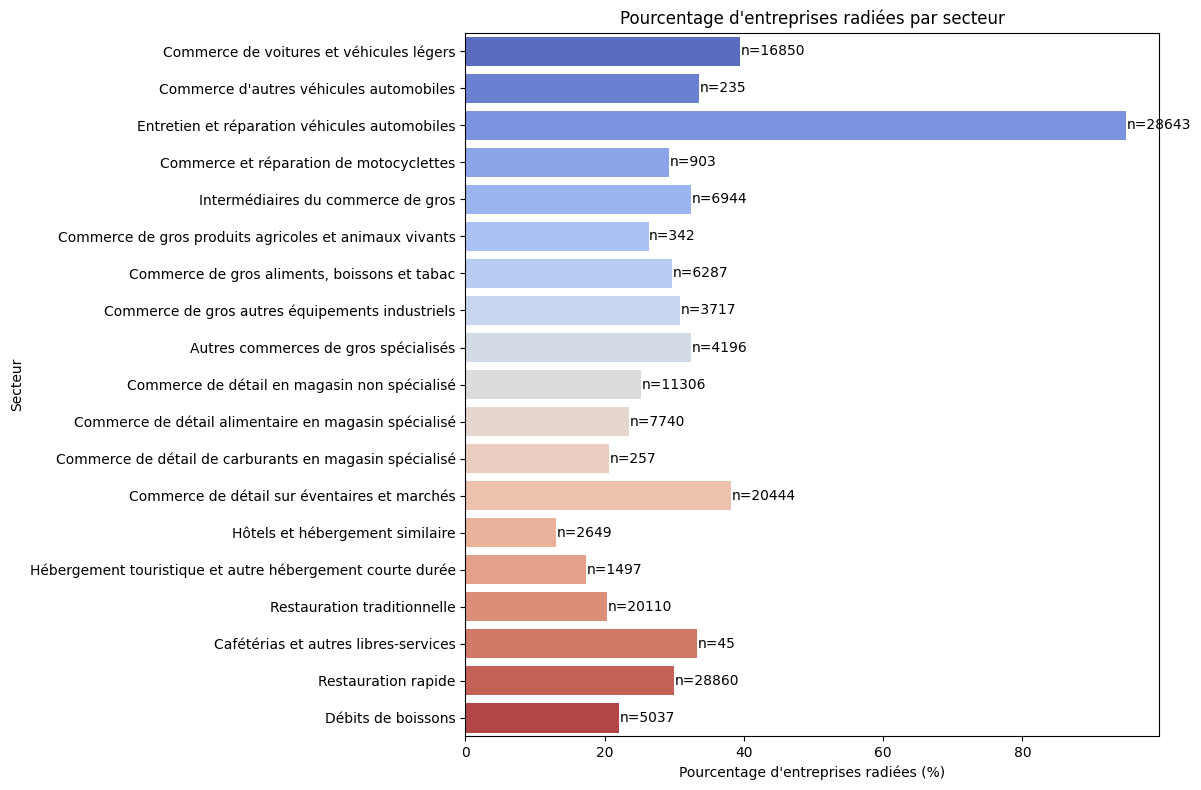

In [133]:
plot_secteur = []

for ape in activites_annotees:
    count_radie = data[["radié","codeAPE"]].loc[data["codeAPE"].str.startswith(ape[0])]["radié"].sum()
    nb_ape = data.loc[data["ape_min"] == ape[0]].shape[0]
    count_relatif = (count_radie/nb_ape) * 100
    des = ape[1]
    nb_ape = data.loc[data["codeAPE"].str.startswith(ape)].shape[0]
    plot_secteur.append((des,count_relatif,nb_ape))

df_plot = pd.DataFrame(plot_secteur, columns=["Secteur", "Pourcentage","NbCreees"])

plt.figure(figsize=(12,8))
ax = sns.barplot(x="Pourcentage", y="Secteur", data=df_plot, palette="coolwarm")


for i, row in df_plot.iterrows():
    ax.text(row["Pourcentage"] + 0.1, i, f"n={row['NbCreees']}", color='black', va="center")

plt.xlabel("Pourcentage d'entreprises radiées (%)")
plt.title("Pourcentage d'entreprises radiées par secteur")
plt.tight_layout()
plt.show()


/tmp/ipykernel_11815/340900453.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



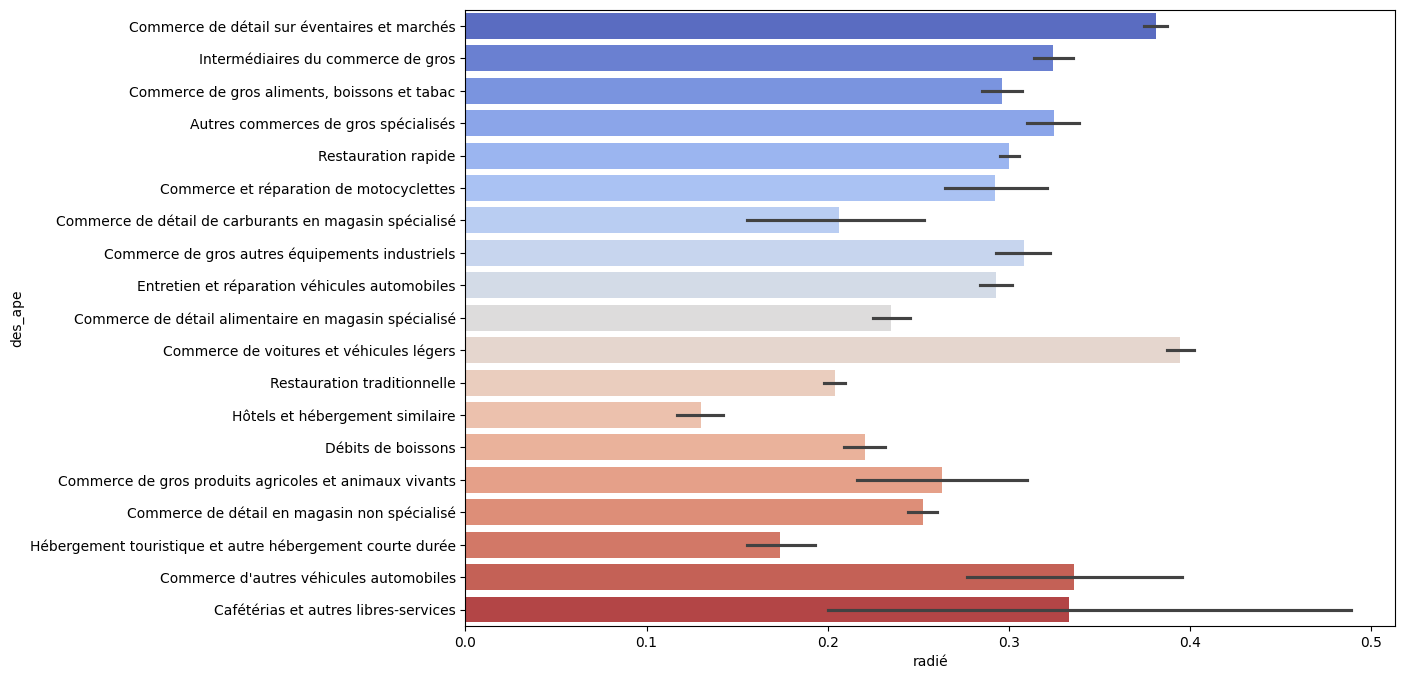

In [136]:
plt.figure(figsize=(12,8))
sns.barplot(x = "radié", y = "des_ape", data = data,palette="coolwarm")
plt.show()

/tmp/ipykernel_11815/4239016213.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



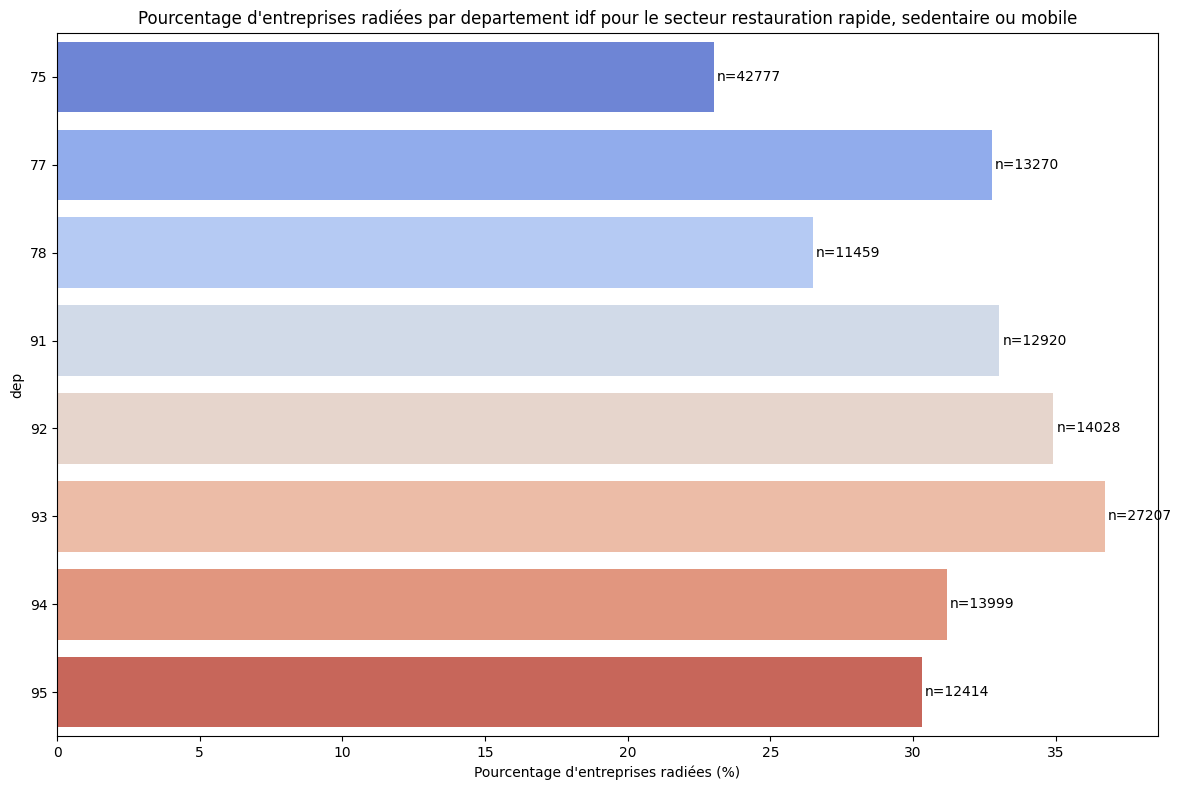

In [137]:
plot_secteur = []

for ape in dep:
    count_radie = data[["radié","codeAPE","cp"]].loc[(data["codeAPE"].str.startswith("5610C"))& (data["cp"] == ape)]["radié"].sum()
    nb_ape = data.loc[(data["codeAPE"].str.startswith("5610C")) & (data["cp"]==ape)].shape[0]
    count_relatif = (count_radie/nb_ape) * 100
    des = ape
    nb_ape = data.loc[data["cp"] == ape].shape[0]
    plot_secteur.append((des,count_relatif,nb_ape))

df_plot = pd.DataFrame(plot_secteur, columns=["dep", "Pourcentage","NbCreees"])

plt.figure(figsize=(12,8))
ax = sns.barplot(x="Pourcentage", y="dep", data=df_plot, palette="coolwarm")

# Ajouter le nombre d'entreprises créées à la fin des barres
for i, row in df_plot.iterrows():
    ax.text(row["Pourcentage"] + 0.1, i, f"n={row['NbCreees']}", color='black', va="center")

plt.xlabel("Pourcentage d'entreprises radiées (%)")
plt.title("Pourcentage d'entreprises radiées par departement idf pour le secteur restauration rapide, sedentaire ou mobile")
plt.tight_layout()
plt.show()

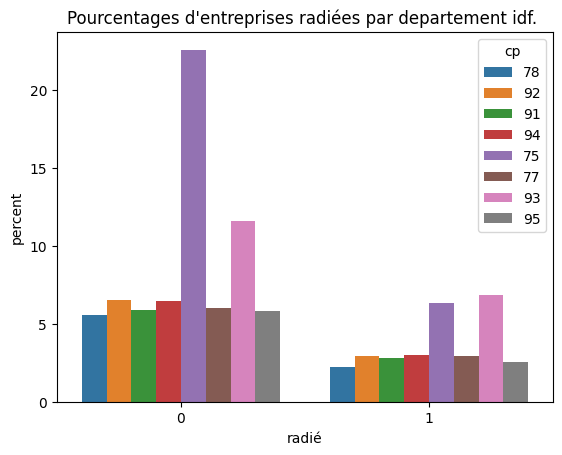

In [138]:
plt.figure()
sns.countplot(x="radié",hue="cp",data=data,stat = "percent")
plt.title("Pourcentages d'entreprises radiées par departement idf. ")
plt.show()